# Section 1 - Load apps


In [1]:
# Initial imports and setup
import datetime as dt
import sys
import warnings
import os
import numpy as np
import pandas as pd
import xarray as xr
import datacube
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import odc.geo.xr
from ipyleaflet import GeoData
from time import time as time
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from matplotlib import colormaps
from matplotlib.patches import Patch

from IPython.display import display
from ipywidgets import widgets

warnings.filterwarnings("ignore")

# Setup paths and Datacube instance
current_dir = os.getcwd()
tools_path = os.path.join(current_dir, "Tools")
working_path = os.path.join(current_dir, "Working")

sys.path.insert(1, tools_path)
sys.path.insert(1, working_path)
dc = datacube.Datacube()

# Ensure openpyxl and tqdm are installed
!pip install openpyxl tqdm

time_range = None

# Function to import display_tools.py if exists
def import_display_tools(path):
    if os.path.exists(path) and "display_tools.py" in os.listdir(path):
        try:
            from display_tools import display_da
            print(f"display_tools module imported successfully from {path}.")
        except ImportError as e:
            print(f"Error importing display_tools from {path}: {e}")
    else:
        print(f"display_tools.py not found in {path}.")

# Function to import landcover.py if exists
def import_landcover(path):
    if os.path.exists(path) and "landcover.py" in os.listdir(path):
        try:
            from landcover import lc_colourmap, make_colorbar, plot_land_cover
            print(f"landcover module imported successfully from {path}.")
        except ImportError as e:
            print(f"Error importing landcover from {path}: {e}")
    else:
        print(f"landcover.py not found in {path}.")

# Import modules
import_display_tools(tools_path)
import_display_tools(working_path)
import_landcover(working_path)

# List files in Tools and Working
def list_files(path):
    if os.path.exists(path):
        print(f"Files in {path}:")
        print(os.listdir(path))
    else:
        print(f"{path} does not exist.")

list_files(tools_path)
list_files(working_path)

print("Section 1: Initial imports and setup - Completed")

# Manually invoke garbage collection without printing the result
import gc
import contextlib
with contextlib.redirect_stdout(None):
    gc.collect()

# Additional imports and setup
from odc.algo import xr_reproject
from dea_tools.plotting import rgb, display_map
from dea_tools.datahandling import wofs_fuser
from dea_tools.plotting import plot_wo
from matplotlib import colors as mcolours
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils import masking
from datacube.utils.masking import mask_invalid_data
from datacube.utils.cog import write_cog
from odc.geo.geom import Geometry

# For DEA burn mapping
from datetime import datetime, timedelta

from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)


display_tools.py not found in /home/jovyan/Living_Coasts_training/Tools.
display_tools.py not found in /home/jovyan/Living_Coasts_training/Working.
landcover.py not found in /home/jovyan/Living_Coasts_training/Working.
/home/jovyan/Living_Coasts_training/Tools does not exist.
/home/jovyan/Living_Coasts_training/Working does not exist.
Section 1: Initial imports and setup - Completed


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/40621/status,
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/40621/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34669,Workers: 1
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/40621/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:40493,Total threads: 2
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/46341/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:43975,


2024-08-08 15:09:41,626 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:40493' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('dc_load_lifeform-3ad10c6c4fec4fc387e45bec95f46248', 8, 0, 0), ('dc_load_level3-00d666ab17e244ffb120692fbf0b3379', 1, 0, 0), ('dc_load_full_classification-1b28c10eba5a42bc8e20cf0650211783', 9, 0, 0), ('dc_load_water_state-96eabc7babc5498fbc4e7b452ffa008c', 10, 0, 0), ('dc_load_water_seasonality-a008dfb0154345748f7d651951a996cc', 1, 0, 0), ('dc_load_vegetation_cover-e0b137d2f57845e4823be50f31d0d254', 9, 0, 0), ('dc_load_bare_gradation-0385d77476944be88ef61aab36075678', 9, 0, 0), ('dc_load_bare_gradation-0385d77476944be88ef61aab36075678', 6, 0, 0), ('dc_load_intertidal-74a2c1f47fa949979e794e6ef09632bf', 8, 0, 0), ('dc_load_level3-00d666ab17e244ffb120692fbf0b3379', 9, 0, 0), ('dc_load_water_state-96eabc7babc5498fbc4e7b452ffa008c', 8, 0, 0), ('dc_load_lifeform-3ad10c6c4fec4fc387e45bec95f46248', 1, 0, 0

# Section 2 - Area Selection

In [2]:
from ipyleaflet import Map, DrawControl, WidgetControl, basemaps, LayersControl, FullScreenControl, Rectangle
from ipywidgets import Output, Button, VBox, Tab, FloatText, Layout
from shapely.geometry import Polygon
import gc
import sys

# Initialize global variables to store the selected polygon
selected_polygon = None
manual_polygon_layer = None

# Define lat_range and lon_range to avoid NameError in Section 5
lat_range = None
lon_range = None

# Create the map
m = Map(center=[0, 0], zoom=2, basemap=basemaps.Esri.WorldImagery, scroll_wheel_zoom=True, layout=Layout(height='600px'))
m.add_control(LayersControl(position='topright'))
m.add_control(FullScreenControl())

# Output widget to display coordinates
output_draw = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_manual = Output(layout={'border': '1px solid black', 'padding': '5px'})

# Setup the draw control with both polygon and rectangle options
draw_control = DrawControl(
    rectangle={"shapeOptions": {"color": "#0000FF"}},
    polygon={"shapeOptions": {"color": "#00FF00"}},
    circlemarker={},
    polyline={},
    circle={}
)
m.add_control(draw_control)

# Event handler for drawing shapes
def handle_draw(target, action, geo_json):
    global selected_polygon, lat_range, lon_range
    output_draw.clear_output()
    coords = geo_json['geometry']['coordinates'][0]
    selected_polygon = Polygon(coords)
    lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
    lat_range = (min(lats), max(lats))
    lon_range = (min(lons), max(lons))
    with output_draw:
        output_draw.append_stdout("Coordinates:\n")
        output_draw.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
        for lat, lon in zip(lats, lons):
            output_draw.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")

draw_control.on_draw(handle_draw)

# Button to clear drawings and output
clear_button_draw = Button(description='Clear All')
clear_button_manual = Button(description='Clear All')

# Event handler for the clear button
def clear_all(b):
    global selected_polygon, manual_polygon_layer, lat_range, lon_range
    draw_control.clear()
    output_draw.clear_output()
    output_manual.clear_output()
    if manual_polygon_layer:
        m.remove_layer(manual_polygon_layer)
    selected_polygon = None
    manual_polygon_layer = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_draw.on_click(clear_all)
clear_button_manual.on_click(clear_all)

# Create input widgets for manual coordinate entry
latitude = FloatText(description='Latitude:', layout=Layout(width='100%'))
longitude = FloatText(description='Longitude:', layout=Layout(width='100%'))
buffer = FloatText(description='Buffer (deg):', value=0.1, layout=Layout(width='100%'))
update_button = Button(description='Update Map')

# Function to update the map based on manual input values
def update_map_manual(b):
    global manual_polygon_layer, selected_polygon, lat_range, lon_range
    output_manual.clear_output()
    lat = latitude.value
    lon = longitude.value
    buf = buffer.value
    
    if lat is not None and lon is not None and buf is not None:
        bounds = [[lat - buf, lon - buf], [lat + buf, lon + buf]]
        if manual_polygon_layer:
            m.remove_layer(manual_polygon_layer)
        manual_polygon_layer = Rectangle(bounds=bounds, color="blue", fill_opacity=0.2, weight=2)
        m.add_layer(manual_polygon_layer)
        m.fit_bounds(bounds)
        
        selected_polygon = Polygon([(lon - buf, lat - buf), (lon + buf, lat - buf), (lon + buf, lat + buf), (lon - buf, lat + buf), (lon - buf, lat - buf)])
        lat_range = (lat - buf, lat + buf)
        lon_range = (lon - buf, lon + buf)
        
        with output_manual:
            output_manual.append_stdout("Manual Coordinates:\n")
            output_manual.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon - buf:.6f}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon - buf:.6f}\n")
    else:
        with output_manual:
            output_manual.append_stdout("Please fill in all coordinate values.\n")

# Connect the manual update button
update_button.on_click(update_map_manual)

# Tab widget for drawing and manual input
draw_tab = VBox([clear_button_draw, output_draw])
manual_tab = VBox([latitude, longitude, buffer, update_button, clear_button_manual, output_manual])

tab = Tab()
tab.children = [draw_tab, manual_tab]
tab.set_title(0, 'Draw')
tab.set_title(1, 'Manual Input')

# Add the tab control to the map
tab_control = WidgetControl(widget=tab, position='topright')
m.add_control(tab_control)

# Display the map
display(m)

print("Section 2: Select Your Area of Interest - Completed")

# Manually invoke garbage collection
gc.collect()


Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

Section 2: Select Your Area of Interest - Completed


60

# Section 3 - Polygon and Co-ordinates 

The drawn shape was used for selection.
The geopolygon of interest is the following one; 
POLYGON ((150.622619 -23.548102, 150.622619 -23.476953, 150.753091 -23.476953, 150.753091 -23.548102, 150.622619 -23.548102))

Selected Polygon Coordinates:
Latitude: -23.548102, Longitude: 150.622619
Latitude: -23.476953, Longitude: 150.622619
Latitude: -23.476953, Longitude: 150.753091
Latitude: -23.548102, Longitude: 150.753091
Latitude: -23.548102, Longitude: 150.622619

UTM Coordinates:
UTM X: 5350767.113783133, UTM Y: -16518406.771158056
UTM X: 5354518.55619956, UTM Y: -16527978.52797287
UTM X: 5338329.916886517, UTM Y: -16534299.790239763
UTM X: 5334599.457458824, UTM Y: -16524737.810801866
UTM X: 5350767.113783133, UTM Y: -16518406.771158056


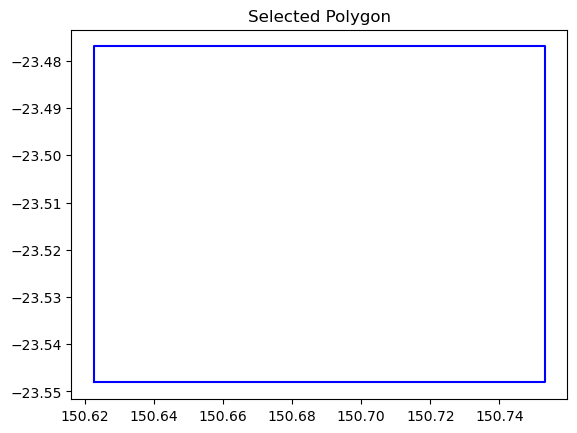

Section 3: Display Selected Coordinates - Completed


In [3]:
import matplotlib.pyplot as plt
from pyproj import Proj
from shapely.geometry.polygon import LinearRing
import gc

# Function to convert latitude and longitude to UTM coordinates
def latlon_to_utm(lat, lon):
    utm_proj = Proj(proj="utm", zone=33, datum="WGS84")  # Change zone as needed
    utm_x, utm_y = utm_proj(lon, lat)
    return utm_x, utm_y

# Function to display the selected coordinates, UTM coordinates, and visualize the polygon
def display_selected_coordinates(selected_polygon):
    if selected_polygon is not None:
        coords = selected_polygon.exterior.coords
        utm_coords = [latlon_to_utm(lat, lon) for lon, lat in coords]

        print("The drawn shape was used for selection.")
        print("The geopolygon of interest is the following one; ")
        print(selected_polygon)

        print("\nSelected Polygon Coordinates:")
        for lon, lat in coords:
            print(f"Latitude: {lat}, Longitude: {lon}")

        print("\nUTM Coordinates:")
        for utm_x, utm_y in utm_coords:
            print(f"UTM X: {utm_x}, UTM Y: {utm_y}")

        # Visualize the selected polygon
        ring = LinearRing(coords)
        fig, ax = plt.subplots()
        ax.plot(*ring.xy, color="blue")
        ax.set_title("Selected Polygon")
        plt.show()
        
        # Explicitly clear variables and run garbage collection
        del coords, utm_coords, ring, fig, ax
        gc.collect()
    else:
        print("No polygon selected")

# Call the function to display the coordinates and visualize the polygon
# Assuming you have the selected polygon stored in a variable named 'selected_polygon'
display_selected_coordinates(selected_polygon)

print("Section 3: Display Selected Coordinates - Completed")


# Section 4 - Date Selection

In [4]:
from datetime import datetime
from IPython.display import display
from ipywidgets import widgets
import gc

# Define a function to update and print the time range
def update_time_range(start_date, end_date):
    time_range = (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
    print(f"Selected time range: {time_range}")
    return time_range

# Input widgets for specifying the year range
start_date_input = widgets.DatePicker(
    description="Start Date", value=datetime(2010, 1, 1)  # Default value (example)
)

end_date_input = widgets.DatePicker(
    description="End Date", value=datetime(2020, 12, 31)  # Default value (example)
)

# Display date pickers
display(start_date_input, end_date_input)

# Attach the update function to the date pickers
def on_date_change(change):
    update_time_range(start_date_input.value, end_date_input.value)

start_date_input.observe(on_date_change, names='value')
end_date_input.observe(on_date_change, names='value')

# Initial call to set the time range
time_range = update_time_range(start_date_input.value, end_date_input.value)

# Free up memory if necessary
_ = gc.collect()  # Store the result in a variable to avoid displaying it


DatePicker(value=datetime.datetime(2010, 1, 1, 0, 0), description='Start Date', step=1)

DatePicker(value=datetime.datetime(2020, 12, 31, 0, 0), description='End Date', step=1)

Selected time range: ('2010-01-01', '2020-12-31')


# Section 5 - DEA Data Load

In [5]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ipywidgets import HTML, VBox
from IPython.display import display
import time
import logging
import threading
import gc

# Suppress garbage collection warnings
logging.getLogger("distributed.utils_perf").setLevel(logging.ERROR)

# Create a dot indicator
spinner = HTML("<b>.</b>")
box = VBox([spinner])
display(box)

# Function to update the spinner
def spin():
    while not done:
        spinner.value = spinner.value + "." if len(spinner.value) < 10 else "<b>.</b>"
        time.sleep(0.5)

# Assume total steps is the number of files/jobs being loaded
total_steps = 10  # Replace with the actual number of steps

# Ensure actual data loading for DEA Land Cover data
done = False
try:
    # Start the spinner in a separate thread
    spinner_thread = threading.Thread(target=spin)
    spinner_thread.start()
    
    # Step 1: Check if required variables are defined
    if lat_range is None or lon_range is None or start_date_input.value is None or end_date_input.value is None:
        raise ValueError("Latitude, Longitude, or Time range is not defined")

    print("Lat Range:", lat_range)
    print("Lon Range:", lon_range)
    print("Start Date:", start_date_input.value)
    print("End Date:", end_date_input.value)

    # Step 2: Construct the query
    query = {
        "y": lat_range,
        "x": lon_range,
        "time": (start_date_input.value, end_date_input.value),
    }

    print("Query Parameters:", query)

    # Step 3: Load DEA Land Cover data from the datacube
    with tqdm(total=total_steps, desc="Loading DEA Land Cover data", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
        lc = dc.load(
            product="ga_ls_landcover_class_cyear_2",
            output_crs="EPSG:3577",
            measurements=[
                "level3",
                "lifeform",
                "vegetation_cover",
                "water_seasonality",
                "water_state",
                "intertidal",
                "water_persistence",
                "bare_gradation",
                "full_classification",
            ],
            resolution=(-25, 25),
            dask_chunks={'time': 1},
            **query
        ).persist()
        # Update the progress bar after each step
        pbar.update(1)  # Adjust the value if multiple steps are combined into one

        # Simulate further steps if necessary
        for _ in range(total_steps - 1):
            time.sleep(0.1)  # Simulate a step taking time
            pbar.update(1)

    pbar.close()  # Close the progress bar to remove it from the output
    print("DEA Land Cover data loaded successfully.")
except Exception as e:
    print(f"Error loading DEA Land Cover data: {e}")
finally:
    # Stop the spinner
    done = True
    spinner_thread.join()

# Remove the spinner
box.close()

# Step 4: Check if the dataset is loaded correctly
if 'lc' not in locals() or lc is None or lc.geobox is None:
    raise ValueError("Failed to load the dataset. Please check the query parameters and ensure data is available for the specified region and time range.")   

# Step 5: Print geobox information
geobox = lc.geobox

geobox_info = f"""
Geobox Information:
-------------------
CRS: {geobox.crs}
Dimensions: {geobox.dimensions}
Resolution: {geobox.resolution}
Shape: {geobox.shape}
Extent: {geobox.extent}
"""

print(geobox_info)

# Step 6: Check loaded data dimensions and variables
print("Loaded data dimensions:", lc.dims)
print("Loaded data variables:", lc.data_vars)

# Free up memory if necessary
_ = gc.collect()  # Suppress the output by assigning it to a variable


Lat Range: (-23.548102, -23.476953)
Lon Range: (150.622619, 150.753091)
Start Date: 2010-01-01 00:00:00
End Date: 2020-12-31 00:00:00
Query Parameters: {'y': (-23.548102, -23.476953), 'x': (150.622619, 150.753091), 'time': (datetime.datetime(2010, 1, 1, 0, 0), datetime.datetime(2020, 12, 31, 0, 0))}


Loading DEA Land Cover data:   0%|          | 0/10 [00:00<?]

DEA Land Cover data loaded successfully.

Geobox Information:
-------------------
CRS: PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3577"]]
Dimensions: ('y', 'x')
Resolution: (-25.0, 25.0)
Shape: (393, 569)
Extent: Geometry({'type': 'Polygon', 'coordinates': (((1875500.0, -2669050.0), (1875500.0, -2678875.0), (1889725.0, -2678875.0), (1889725.0, -2669050.0), (1875500.0, -2669050

# Section 6 - Checkbox Plots

In [6]:
import matplotlib.pyplot as plt
from ipywidgets import Checkbox, VBox, HBox, Button, Output, HTML
from IPython.display import display
from dea_tools.landcover import plot_land_cover

# Section 6: Checkbox widgets for selecting datasets
def create_checkbox(description, initial_value=False):
    return Checkbox(description=description, value=initial_value)

level3_checkbox = create_checkbox('Level 3')
lifeform_checkbox = create_checkbox('Lifeform')
vegetation_cover_checkbox = create_checkbox('Vegetation Cover')
water_state_checkbox = create_checkbox('Water State')
water_persistence_checkbox = create_checkbox('Water Persistence')
full_classification_checkbox = create_checkbox('Full Classification')
item_checkbox = create_checkbox('Intertidal Elevation')

output = Output()

def plot_land_cover_dataset(dataset, title):
    plt.figure()
    plot_land_cover(dataset)
    plt.title(title)
    plt.show()

def plot_selected_datasets():
    with output:
        output.clear_output()
        selected_datasets = {
            'Level 3': (level3_checkbox.value, lc.level3 if 'lc' in globals() else None),
            'Lifeform': (lifeform_checkbox.value, lc.lifeform if 'lc' in globals() else None),
            'Vegetation Cover': (vegetation_cover_checkbox.value, lc.vegetation_cover if 'lc' in globals() else None),
            'Water State': (water_state_checkbox.value, lc.water_state if 'lc' in globals() else None),
            'Water Persistence': (water_persistence_checkbox.value, lc.water_persistence if 'lc' in globals() else None),
            'Full Classification': (full_classification_checkbox.value, lc.full_classification if 'lc' in globals() else None),
            'Intertidal Elevation': (item_checkbox.value, item.elevation[0] if 'item' in globals() else None)
        }

        for title, (is_selected, dataset) in selected_datasets.items():
            if is_selected and dataset is not None:
                plot_land_cover_dataset(dataset, title)
                del dataset  # Free up memory

plot_datasets_button = Button(description='Plot Selected Data')
plot_datasets_button.on_click(lambda b: plot_selected_datasets())

checkboxes_box = HBox([
    level3_checkbox, 
    lifeform_checkbox, 
    vegetation_cover_checkbox, 
    water_state_checkbox, 
    water_persistence_checkbox, 
    full_classification_checkbox,
    item_checkbox
])
display(checkboxes_box)
display(plot_datasets_button)
display(output)


Button(description='Plot Selected Data', style=ButtonStyle())

Output()

# Section 7 - Impacts and Pressure Selection

In [8]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML

# Load the dataset from the specified relative path
#file_path = 'Working/Impacts and pressures_test_June.xlsx'
file_path = 'gct/Impacts and pressures.xlsx'

df = pd.read_excel(file_path, sheet_name='Australia')

# Replace NaN values in 'Impact_ID' and 'Pressure_ID' columns with zeros
df['Impact_ID'] = df['Impact_ID'].fillna(0).astype(int)
df['Pressure_ID'] = df['Pressure_ID'].fillna(0).astype(int)

# Create a mapping from Impact to associated Pressures
impact_to_pressures = df.groupby(['Impacts', 'Impact_ID'])[['Pressures', 'Pressure_ID']].apply(
    lambda x: [f"{row['Pressures']} ({row['Pressure_ID']})" for _, row in x.iterrows()]
).to_dict()

# Define evidence groups
time_columns = ['TimeO_Ev', 'TimeL_Ev', 'TimeM_Ev', 'TimeD_Ev', 'Space_Ev']
level3_columns = ['ModA', 'ModB', 'ModC', 'ModD', 'ModE', 'ModF', 'ModG', 'ModH', 'ModI', 'ConA', 'ConB', 'ConC', 'ConD', 'ConE', 'ConF', 'ConG', 'ConH', 'ConI', 'ConJ', 'ConK', 'ConL', 'ConM', 'ConN', 'ConO', 'ConP']
lifeform_columns = ['LfA', 'LfB', 'LfC', 'LfD']
cover_columns = ['CovA', 'CovB','CovC','CovD','CovE','CovF','CovG','CovH','CovI','CovJ','CovK','CovL','CovM','CovN','CovO','CovP','CovQ','CovR','CovS','CovT','CovU','CovV','CovX']
waterstt_columns = ['Wstate']
waterper_columns = ['WperA', 'WperB', 'WperC', 'WperD', 'WperE', 'WperF']
biomass_columns = ['AGB_Ev', 'AGBSD_Ev']
individual_columns = ['Canopycoa_Ev', 'Fire presence', 'Turbidity']

# Create a dictionary to map each identifier to its associated evidence with values
identifier_to_evidence = {}
for _, row in df.iterrows():
    identifier = row['Impact_ID'] * 1000 + row['Pressure_ID']
    
    # Function to format values
    def format_value(value):
        try:
            return int(value) if pd.notnull(value) and value == int(value) else value
        except (ValueError, TypeError):
            return value

    evidence_with_values = {
        'IP_UID': row['IP_UID'],
        'ID_Colour': row['ID_Colour'],
        'Time_Evidence': [(col, format_value(row[col])) for col in time_columns if pd.notnull(row[col])],
        'Level3_Evidence': [(col, format_value(row[col])) for col in level3_columns if pd.notnull(row[col])],
        'Lifeform_Evidence': [(col, format_value(row[col])) for col in lifeform_columns if pd.notnull(row[col])],
        'Cover_Evidence': [(col, format_value(row[col])) for col in cover_columns if pd.notnull(row[col])],
        'Waterstt_Evidence': [(col, format_value(row[col])) for col in waterstt_columns if pd.notnull(row[col])],
        'Waterper_Evidence': [(col, format_value(row[col])) for col in waterper_columns if pd.notnull(row[col])],
        'Biomass_Evidence': [(col, format_value(row[col])) for col in biomass_columns if pd.notnull(row[col])]
    }
    identifier_to_evidence[identifier] = evidence_with_values

# Create the dropdown widgets for impacts and pressures with IDs
impact_dropdown = widgets.Dropdown(
    options=[f"{impact} ({impact_id})" for (impact, impact_id) in impact_to_pressures.keys()],
    description='Impact:',
    value=None  # Start without a selection
)

pressure_dropdown = widgets.Dropdown(
    options=['Please select an Impact first'],
    description='Pressure:',
    value=None  # Start without a selection
)

# Define the output widget for displaying the calculation result and evidence
output = widgets.Output()

# Define the function to update pressure dropdown based on selected impact
def on_impact_change(change):
    selected_impact = change['new']
    if selected_impact:
        impact, impact_id = selected_impact.rsplit(' (', 1)
        impact_id = int(impact_id.rstrip(')'))
        pressures = impact_to_pressures.get((impact, impact_id), [])
        pressure_dropdown.options = pressures
    else:
        pressure_dropdown.options = ['Please select an Impact first']

# Define the function to display the selected impact and pressure
def display_selection(impact, pressure):
    global selected_ip_uid  # Make IP_UID global to be accessible in Section 8

    with output:
        output.clear_output()
        if impact and pressure:
            impact_id = int(impact.rsplit(' (', 1)[1].rstrip(')'))
            pressure_id = int(pressure.rsplit(' (', 1)[1].rstrip(')'))
            identifier = impact_id * 1000 + pressure_id

            if identifier in identifier_to_evidence:
                evidence = identifier_to_evidence[identifier]
                selected_ip_uid = evidence["IP_UID"]  # Set the selected IP_UID
                display(HTML(f'<strong>Selected Impact:</strong> {impact}'))
                display(HTML(f'<strong>Selected Pressure:</strong> {pressure}'))
                display(HTML(f'<strong>Identifier:</strong> {identifier}'))
                display(HTML(f'<strong>IP_UID:</strong> {evidence["IP_UID"]}'))
                display(HTML(f'<strong>ID_Colour:</strong> {evidence["ID_Colour"]}'))
                display(HTML('<strong>Evidence:</strong>'))
                for group, values in evidence.items():
                    if group not in ['IP_UID', 'ID_Colour'] and values:
                        display(HTML(f'<strong>{group.replace("_", " ")}:</strong>'))
                        for evidence_name, value in values:
                            display(HTML(f'- {evidence_name}: {value}'))
            else:
                display(HTML('<strong>Error:</strong> No evidence found for the selected Impact and Pressure.'))
        else:
            display(HTML('<strong>Please select both an impact and a pressure.</strong>'))

# Set up observation for changes in the impact dropdown
impact_dropdown.observe(on_impact_change, names='value')

# Set up interaction to display selections
interactive_selection = widgets.interactive(display_selection, impact=impact_dropdown, pressure=pressure_dropdown)

# Arrange the widgets and the output display
display(widgets.VBox([impact_dropdown, pressure_dropdown, output]))

# Free up memory by removing the dataframe
del df


# Section 8 - Impacts and Pressure Evidence with Bar Plot


In [9]:
# Ensure actual data loading is in place of random data
# Load actual data for level3 and lifeform changes
start_l3 = lc.level3[0].astype(np.int32)
end_l3 = lc.level3[-1].astype(np.int32)
ignore_no_change = False
change_vals_l3 = (start_l3 * 1000) + end_l3
if ignore_no_change:
    change_vals_l3 = np.where(start_l3 == end_l3, 0, change_vals_l3)
level_3 = lc.level3[0].drop_vars("time")

obs_change_l3_t1_t2 = xr.DataArray(
    data=change_vals_l3,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)
obs_change_l3 = obs_change_l3_t1_t2.to_dataset(name="l3_t1_t2")

# Load actual data for lifeform changes
start_lf = lc.lifeform[0].astype(np.int32)
end_lf = lc.lifeform[-1].astype(np.int32)
change_vals_lf = (start_lf * 10) + end_lf
if ignore_no_change:
    change_vals_lf = np.where(start_lf == end_lf, 0, change_vals_lf)
lifeform = lc.lifeform[0].drop_vars("time")

obs_change_lf_t1_t2 = xr.DataArray(
    data=change_vals_lf,
    coords=lifeform.coords,
    dims=lifeform.dims,
    name="observed change",
    attrs=lifeform.attrs,
    fastpath=False,
)
obs_change_lf = obs_change_lf_t1_t2.to_dataset(name="lf_t1_t2")
del obs_change_lf_t1_t2

# cover
start_cover = lc.vegetation_cover[0].astype(np.int32)
end_cover = lc.vegetation_cover[-1].astype(np.int32)
change_vals_cover = (start_cover * 100) + end_cover
if ignore_no_change:
    change_vals_cover = np.where(start_cover == end_cover, 0, change_vals_cover)
cover = lc.vegetation_cover[0].drop_vars("time")

obs_change_cover_t1_t2 = xr.DataArray(
    data=change_vals_cover,
    coords=cover.coords,
    dims=cover.dims,
    name="vegetation cover change",
    attrs=cover.attrs,
    fastpath=False,
)
obs_change_cover = obs_change_cover_t1_t2.to_dataset(name="cover_t1_t2")
del obs_change_cover_t1_t2

# Water state
start_waterstt = lc.water_state[0].astype(np.int32)
end_waterstt = lc.water_state[-1].astype(np.int32)
change_vals_waterstt = (start_waterstt * 10) + end_waterstt
if ignore_no_change:
    change_vals_waterstt = np.where(start_waterstt == end_waterstt, 0, change_vals_waterstt)
waterstt = lc.water_state[0].drop_vars("time")

obs_change_waterstt_t1_t2 = xr.DataArray(
    data=change_vals_waterstt,
    coords=waterstt.coords,
    dims=waterstt.dims,
    name="water state change",
    attrs=waterstt.attrs,
    fastpath=False,
)
obs_change_waterstt = obs_change_waterstt_t1_t2.to_dataset(name="waterstt_t1_t2")
del obs_change_waterstt_t1_t2

# Water persistence
start_waterper = lc.water_persistence[0].astype(np.int32)
end_waterper = lc.water_persistence[-1].astype(np.int32)
change_vals_waterper = (start_waterper * 10) + end_waterper
if ignore_no_change:
    change_vals_waterper = np.where(start_waterper == end_waterper, 0, change_vals_waterper)
waterper = lc.water_persistence[0].drop_vars("time")

obs_change_waterper_t1_t2 = xr.DataArray(
    data=change_vals_waterper,
    coords=waterper.coords,
    dims=waterper.dims,
    name="water persistence change",
    attrs=waterper.attrs,
    fastpath=False,
)
obs_change_waterper = obs_change_waterper_t1_t2.to_dataset(name="waterper_t1_t2")
del obs_change_waterper_t1_t2

### Create individual masks for changes in Level 3 and Environmental Descriptors

In [10]:
# Function to create and display individual masks and calculate area percentages
def create_and_display_individual_masks():
    global selected_ip_uid

    # Debug: Print selected IP_UID
    print(f"Selected IP_UID: {selected_ip_uid}")

    # Extract the relevant evidence values based on the selected IP_UID
    evidence = next((v for k, v in identifier_to_evidence.items() if v['IP_UID'] == selected_ip_uid), None)
    if evidence is None:
        print(f"No evidence found for IP_UID {selected_ip_uid}")
        return

    selected_time_values = [(name, value) for name, value in evidence['Time_Evidence']]
    selected_level3_values = [(name, value) for name, value in evidence['Level3_Evidence']]
    selected_lifeform_values = [(name, value) for name, value in evidence['Lifeform_Evidence']]
    selected_cover_values = [(name, value) for name, value in evidence['Cover_Evidence']]
    selected_waterstt_values = [(name, value) for name, value in evidence['Waterstt_Evidence']]
    selected_waterper_values = [(name, value) for name, value in evidence['Waterper_Evidence']]
    selected_biomass_values = [(name, value) for name, value in evidence['Biomass_Evidence']]
    plot_titles = []  
    
    # List to store plot titles and their area percentages

    def plot_and_calculate_area(data, title, color_map):
        fig, ax = plt.subplots(figsize=(10, 6))
        data.plot(ax=ax, cmap=color_map)
        fig.suptitle(f"IP_UID: {selected_ip_uid}", fontsize=16, y=1.05)
        ax.set_title(title)
        plt.tight_layout()
        plt.show()
        
        # Calculate the area percentage
        total_area = np.prod(data.shape)  # Total number of pixels
        area = np.sum(data.values)  # Number of pixels with value 1
        area_percentage = (area / total_area) * 100  # Convert to percentage

        print(f"Title: {title}, Area: {area}, Total Area: {total_area}, Area Percentage: {area_percentage}%")
        plot_titles.append((title, area_percentage))
    
    if selected_level3_values:
        for name, lvl3_val in selected_level3_values:
            change_l3 = np.where(
                (obs_change_l3.l3_t1_t2 == lvl3_val),
                1,
                0
            )

            change_xr_l3 = xr.DataArray(
                data=change_l3,
                coords=obs_change_l3.coords,
                dims=obs_change_l3.dims,
                name="Change",
                attrs=None
            )

            change_ds_l3 = change_xr_l3.to_dataset(name="Change")  
            plot_and_calculate_area(change_ds_l3.Change, f"{name} Change Mask for Value {lvl3_val}", 'Reds')
    
    if selected_lifeform_values:
        for name, lf_val in selected_lifeform_values:
            change_lf = np.where(
                (obs_change_lf.lf_t1_t2 == lf_val),
                1,
                0
            )

            change_xr_lf = xr.DataArray(
                data=change_lf,
                coords=obs_change_lf.coords,
                dims=obs_change_lf.dims,
                name="Change",
                attrs=None
            )

            change_ds_lf = change_xr_lf.to_dataset(name="Change")
            plot_and_calculate_area(change_ds_lf.Change, f"{name} Change Mask for Value {lf_val}", 'Blues')
            
    if selected_cover_values:
        for name, cover_val in selected_cover_values:
            change_cover = np.where(
                (obs_change_cover.cover_t1_t2 == cover_val),
                1,
                0
            )

            change_xr_cover = xr.DataArray(
                data=change_cover,
                coords=obs_change_cover.coords,
                dims=obs_change_cover.dims,
                name="Change",
                attrs=None
            )

            change_ds_cover = change_xr_cover.to_dataset(name="Change")
            plot_and_calculate_area(change_ds_cover.Change, f"{name} Change Mask for Value {cover_val}", 'Greens')
 
    if selected_waterstt_values:
        for name, waterstt_val in selected_waterstt_values:
            change_waterstt = np.where(
                (obs_change_waterstt.waterstt_t1_t2 == waterstt_val),
                1,
                0
            )

            change_xr_waterstt = xr.DataArray(
                data=change_waterstt,
                coords=obs_change_waterstt.coords,
                dims=obs_change_waterstt.dims,
                name="Change",
                attrs=None
            )

            change_ds_waterstt = change_xr_waterstt.to_dataset(name="Change")
            plot_and_calculate_area(change_ds_waterstt.Change, f"{name} Change Mask for Value {waterstt_val}", 'Blues')    

    if selected_waterper_values:
        for name, waterper_val in selected_waterper_values:
            change_waterper = np.where(
                (obs_change_waterper.waterper_t1_t2 == waterper_val),
                1,
                0
            )

            change_xr_waterper = xr.DataArray(
                data=waterper,
                coords=obs_change_waterper.coords,
                dims=obs_change_waterper.dims,
                name="Change",
                attrs=None
            )

            change_ds_waterper = change_xr_waterper.to_dataset(name="Change")
            plot_and_calculate_area(change_ds_waterper.Change, f"{name} Change Mask for Value {waterper_val}", 'Purples')






### Generate summary plot of changes

In [11]:
    # Ensure there are values to plot
    if not plot_titles:
        print("No data to plot.")
        return

    # Create bar chart with each bar colored differently
    labels, area_percentages = zip(*plot_titles)
    area_percentages = np.array(area_percentages)
    
    # Normalize percentages for coloring
    norm = plt.Normalize(area_percentages.min(), area_percentages.max())
    colors = cm.viridis(norm(area_percentages))
    
    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.barh(labels, area_percentages, color=colors)
    
    # Add color bar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('%')

    #ax.set_xlabel('Percentage Area')
    ax.set_title('Change %')
    plt.tight_layout()
    plt.show()

# Call the function to create and display the masks and calculate area percentages
create_and_display_individual_masks()

SyntaxError: 'return' outside function (1839520879.py, line 4)

### Input other evidence sources

In [12]:
    # For the other evidence types, you would need to replace random data with actual data loading and processing
    evidence_types = [
        (selected_time_values, 'Greens'),
#        (selected_water_values, 'Purples'),
#        (selected_biomass_values, 'Oranges'),
#        (selected_pressure_values, 'YlGn')
    ]
    
    for values, cmap in evidence_types:
        for name, val in values:
            # Replace with actual data loading and processing for each type
            change_data = np.random.random((len(level_3['y']), len(level_3['x'])))  # Use actual data here

            change_xr = xr.DataArray(
                data=change_data,
                coords=level_3.coords,
                dims=level_3.dims,
                name="Change",
                attrs=None
            )
            change_ds = change_xr.to_dataset(name="Change")
            plot_and_calculate_area(change_ds.Change, f"{name} Change Mask for Value {val}", cmap)

NameError: name 'selected_time_values' is not defined